This file was predominantly created by prompting AI. 

In [1221]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os 
import matplotlib.ticker as ticker
from main import evaluate
from opponent import make_opponent
from gymnasium import spaces
from TD3_agent import TD3_Agent
import hockey.hockey_env as hockey_env


In [1222]:
# STYLE SETUP
plt.rcParams.update({
    'figure.facecolor':     'white',#'#fafafa',
    'axes.facecolor':       'white', #'#fafafa',
    'axes.edgecolor':       '#cccccc',
    'axes.grid':            True,
    'axes.spines.top':      False,
    'axes.spines.right':    False,
    'axes.xmargin':         0.01,
    'axes.ymargin':         0.0,   
    'grid.alpha':           0.3,
    'grid.color':           '#888888',
    'grid.linestyle':       '--',
    'font.family':          'sans-serif',
    'font.sans-serif':      ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size':            11,
    'axes.titlesize':       14,
    'axes.titleweight':     'bold',
    'axes.labelsize':       12,
    'legend.fontsize':      12,
    'legend.frameon':       False,
    #'legend.framealpha':    0.9,
    'legend.edgecolor':     '#cccccc',
    'figure.dpi':           130,
    'savefig.dpi':          200,
    'savefig.bbox':         'tight',
})

COLORS = ['#2176AE', # blue
          '#57A773', # green
          '#D4A843', # yellow
          '#E87EA1', # pink
          '#E05A3A', # orange
          '#8B5FBF', # purple
          '#27EEF5', # turquoise
          '#F52754', # red
          '#B2DE90', # light green
          ]

In [1223]:
# Noise-type color mapping (inspired by colored noise spectrum)
NOISE_COLORS = {
    "P":  '#D45B90',  #"#E87EA1",   # pink noise → pink
    "OU": "#C0392B",   # Ornstein-Uhlenbeck ≈ red/brown noise → red
    "G":  "#2B2B2B",   # Gaussian = white noise → dark charcoal
}

def get_noise_color(label: str) -> str:
    first_part = label.split(",")[0].split("\n")[0].strip()
    if first_part.startswith("OU"):
        return NOISE_COLORS["OU"]
    elif first_part.startswith("G"):
        return NOISE_COLORS["G"]
    elif first_part.startswith("P"):
        return NOISE_COLORS["P"]
    return "#333333"

In [1224]:
# Extended color mapping: lighter = no PER, darker/saturated = with PER
NOISE_COLORS_FULL = {
    "G":       "#888888",   # light grey
    "G + PER": "#2B2B2B",   # dark charcoal
    "OU":      "#E07060",   # light red
    "OU + PER":"#C0392B",   # dark red
    "P":       "#E8A0B8",   # light pink
    "P + PER": "#D45B90",   # saturated pink
}

def get_noise_color_full(label: str) -> str:
    """Match full label (including +PER) to a shade."""
    clean = label.split("\n")[0].strip()
    if clean in NOISE_COLORS_FULL:
        return NOISE_COLORS_FULL[clean]
    return get_noise_color(label)  # fallback to base color

In [1225]:
def get_line_style(label: str) -> dict:
    has_per = "PER" in label
    return {
        "linestyle": "-"  if has_per else (5, (4, 1.5)),  # solid vs long dash
        "linewidth": 2.5  if has_per else 2,
    }

In [1226]:
def sort_legend(handles, labels):
    LEGEND_ORDER = ["G", "G + PER", "OU", "OU + PER", "P", "P + PER"]
    order_map = {name: i for i, name in enumerate(LEGEND_ORDER)}
    paired = list(zip(handles, labels))
    paired.sort(key=lambda x: order_map.get(x[1], 999))
    return zip(*paired)

# Load the selected agents

In [1227]:
def load_logs(map: dict) -> dict:
    runs = {}
    for label, path in map.items():
        if not os.path.exists(path):
            print(f"skipping {label}: {path} not found")
            continue
        df = pd.read_csv(path)
        df.columns = df.columns.str.strip()
        runs[label] = df
    return runs

In [1228]:
# load the data 
TRAINING_wins_map = {"weak": {
    "G\n1991359": "/Users/Anne/RL/Hockey-TD3/1991359/logs/win_rate_log.csv", 
    "G + PER\n1991358": "/Users/Anne/RL/Hockey-TD3/1991358/logs/win_rate_log.csv",
    "OU + PER\n1986413": "./1986413/logs/win_rate_log.csv",
    "OU\n1986415": "/Users/Anne/RL/Hockey-TD3/1986415/logs/win_rate_log.csv",
    "P\n1991360": "/Users/Anne/RL/Hockey-TD3/1991360/logs/win_rate_log.csv",
    "P + PER\n1991357": "/Users/Anne/RL/Hockey-TD3/1991357/logs/win_rate_log.csv",
},
"strong": {
    "G + PER\n1986633": "./1986633/logs/win_rate_log.csv",
    "G\n1991413": "/Users/Anne/RL/Hockey-TD3/1991413/logs/win_rate_log.csv",
    "OU + PER\n1986620": "./1986620/logs/win_rate_log.csv",
    "OU\n1991415": "/Users/Anne/RL/Hockey-TD3/1991415/logs/win_rate_log.csv",
    "P + PER\n1986341": "./1986341/logs/win_rate_log.csv",
    "P\n1991412": "/Users/Anne/RL/Hockey-TD3/1991412/logs/win_rate_log.csv"
}} 


In [1229]:
def wins_map_to_log_map(wins_map: dict) -> dict:
    """Convert win_rate_log.csv paths to training_log.csv paths."""
    return {
        opponent: {
            label: path.replace("win_rate_log.csv", "training_log.csv")
            for label, path in runs.items()
        }
        for opponent, runs in wins_map.items()
    }

TRAINING_log_map = wins_map_to_log_map(TRAINING_wins_map)
TRAINING_log_map

{'weak': {'G\n1991359': '/Users/Anne/RL/Hockey-TD3/1991359/logs/training_log.csv',
  'G + PER\n1991358': '/Users/Anne/RL/Hockey-TD3/1991358/logs/training_log.csv',
  'OU + PER\n1986413': './1986413/logs/training_log.csv',
  'OU\n1986415': '/Users/Anne/RL/Hockey-TD3/1986415/logs/training_log.csv',
  'P\n1991360': '/Users/Anne/RL/Hockey-TD3/1991360/logs/training_log.csv',
  'P + PER\n1991357': '/Users/Anne/RL/Hockey-TD3/1991357/logs/training_log.csv'},
 'strong': {'G + PER\n1986633': './1986633/logs/training_log.csv',
  'G\n1991413': '/Users/Anne/RL/Hockey-TD3/1991413/logs/training_log.csv',
  'OU + PER\n1986620': './1986620/logs/training_log.csv',
  'OU\n1991415': '/Users/Anne/RL/Hockey-TD3/1991415/logs/training_log.csv',
  'P + PER\n1986341': './1986341/logs/training_log.csv',
  'P\n1991412': '/Users/Anne/RL/Hockey-TD3/1991412/logs/training_log.csv'}}

In [1230]:
def strip_job_ids(wins_map: dict) -> dict:
    """Strip job IDs from labels, keeping only noise + buffer config."""
    cleaned = {}
    for opponent, runs in wins_map.items():
        cleaned[opponent] = {}
        for label, path in runs.items():
            clean_label = label.split("\n")[0].strip()
            cleaned[opponent][clean_label] = path
    return cleaned

TRAINING_wins_map = strip_job_ids(TRAINING_wins_map)
TRAINING_log_map = strip_job_ids(TRAINING_log_map)

In [1231]:
RENAME_MAP = {
    "G":        "Gaussian",
    "G + PER":  "Gaussian + PER",
    "OU":       "Ornstein-U.",
    "OU + PER": "Ornstein-U. + PER",
    "P":        "Pink",
    "P + PER":  "Pink + PER",
}

def rename_labels(wins_map: dict) -> dict:
    return {
        opponent: {RENAME_MAP.get(label, label): path for label, path in runs.items()}
        for opponent, runs in wins_map.items()
    }

In [1232]:
NOISE_COLORS = {
    "Pink":       '#D45B90',
    "Ornstein-U.": "#C0392B",
    "Gaussian":   "#2B2B2B",
}

NOISE_COLORS_FULL = {
    "Gaussian":          "#888888",
    "Gaussian + PER":    "#2B2B2B",
    "Ornstein-U.":       "#E07060",
    "Ornstein-U. + PER": "#C0392B",
    "Pink":              "#E8A0B8",
    "Pink + PER":        "#D45B90",
}

def get_noise_color(label: str) -> str:
    clean = label.split("\n")[0].strip()
    for key in NOISE_COLORS:
        if clean.startswith(key):
            return NOISE_COLORS[key]
    return "#333333"

LEGEND_ORDER = ["Gaussian", "Gaussian + PER", "Ornstein-U.", "Ornstein-U. + PER", "Pink", "Pink + PER"]

TRAINING_wins_map = rename_labels(strip_job_ids(TRAINING_wins_map))
TRAINING_log_map = rename_labels(strip_job_ids(TRAINING_log_map))

In [1233]:
weak_runs = load_logs(TRAINING_wins_map["weak"])
strong_runs = load_logs(TRAINING_wins_map["strong"])

weak_training = load_logs(TRAINING_log_map["weak"])
strong_training = load_logs(TRAINING_log_map["strong"])


In [1234]:
# check
for label in TRAINING_wins_map["strong"]:
    print(f"{label!r} → {get_noise_color(label)}")

'Gaussian + PER' → #2B2B2B
'Gaussian' → #2B2B2B
'Ornstein-U. + PER' → #C0392B
'Ornstein-U.' → #C0392B
'Pink + PER' → #D45B90
'Pink' → #D45B90


# Final plot (3 panels)

In [1235]:
EPISODE_MAX = 9_000

In [1236]:
NOISE_COLORS = {
    "Pink":        "#E87EA1",                      #"#E0598B",   # warm, vivid pink
    "Ornstein-U.": "#D4760A",                 #"#B44040",   # brick red — less aggressive than #C0392B
    "Gaussian":    "#444444",    #"#2B2B2B",   # charcoal (unchanged)
}

NOISE_COLORS_FULL = {
    "Gaussian":          "#888888",
    "Gaussian + PER":    "#2B2B2B",
    "Ornstein-U.":       "#D4807A",   # muted salmon
    "Ornstein-U. + PER": "#B44040",   # brick red
    "Pink":              "#EFA4BE",   # soft pink
    "Pink + PER":        "#E0598B",   # vivid pink
}

In [1237]:
NOISE_COLORS = {
    "Pink":        "#E07095", #"#E87EA1",
    "Ornstein-U.": "#A85E10", #""#D4760A",
    "Gaussian":    "#444444",
}

NOISE_COLORS_FULL = {
    "Gaussian":          "#999999",
    "Gaussian + PER":    "#444444",
    "Ornstein-U.":       "#E07060",
    "Ornstein-U. + PER": "#C0392B",
    "Pink":              "#E8A0B8",
    "Pink + PER":        "#E87EA1",
}

In [1251]:
LEGEND_ORDER = ["Gaussian", "Gaussian + PER", "Ornstein-U.", "Ornstein-U. + PER", "Pink", "Pink + PER"]

In [1265]:
def plot_three_panel(weak_win_runs, strong_win_runs, strong_ep_runs,
                     ep_smoothing=100, figsize=(16, 4.5), dpi=100):
    """
    Three-panel figure:
      (A) Win rate vs weak BasicOpponent
      (B) Win rate vs strong BasicOpponent
      (C) Episode length vs strong BasicOpponent
    """
    import matplotlib.ticker as mticker

    fig, axes = plt.subplots(1, 3, figsize=figsize, dpi=dpi)
    all_handles, all_labels = [], []

    # ── Panel A: win rate vs weak ────────────────────────────────
    ax = axes[0]
    for label, df in weak_win_runs.items():
        c = get_noise_color(label)
        line_style = get_line_style(label)
        ax.plot(df["episode"], df["win_rate"], color=c, label=label, **line_style)

    ax.set_title("(A) Win rate - Training vs weak")
    ax.set_ylabel("Win rate")
    ax.set_ylim(-0.05, 1.05)
    ax.axhline(0.55, color="#aaaaaa", linestyle="--", linewidth=1, alpha=0.8)
    ax.text(EPISODE_MAX * 0.97, 0.555, "55% threshold", ha="right", va="bottom",
            fontsize=8, color="#aaaaaa")
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))

    # ── Panel B: win rate vs strong ──────────────────────────────
    ax = axes[1]
    for label, df in strong_win_runs.items():
        c = get_noise_color(label)
        line_style = get_line_style(label)
        ax.plot(df["episode"], df["win_rate"], color=c, label=label, **line_style)

    ax.set_title("(B) Win rate - Training vs strong")
    ax.set_ylim(-0.05, 1.05)
    ax.axhline(0.55, color="#aaaaaa", linestyle="--", linewidth=1, alpha=0.8)
    ax.text(EPISODE_MAX * 0.98, 0.555, "55% threshold", ha="right", va="bottom",
            fontsize=8, color="#aaaaaa")
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))

    # ── Panel C: episode length vs strong ────────────────────────
    ax = axes[2]
    for label, df in strong_ep_runs.items():
        c = get_noise_color_full(label)
        line_style = get_line_style(label)
        smooth = df["episode_length"].rolling(ep_smoothing, min_periods=1).mean()
        ax.plot(df["episode"], smooth, color=c, label=label, linewidth=1)

    ax.set_title("(C) Game length - training vs strong")
    ax.set_ylabel("Episode length (steps)")
    ax.axhline(250, color="#aaaaaa", linestyle="--", linewidth=1.7, alpha=0.8)
    ax.text(EPISODE_MAX * 0.97, 252, "Max (250)",
            ha="right", va="bottom", fontsize=8, color="#aaaaaa")
    axes[2].xaxis.set_major_locator(mticker.MaxNLocator(5))

    # ── Shared formatting ────────────────────────────────────────
    for ax in axes:
        ax.set_xlabel("Training episode")
        ax.set_xlim(0, EPISODE_MAX)
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

        h, l = ax.get_legend_handles_labels()
        for hi, li in zip(h, l):
            if li not in all_labels:
                all_handles.append(hi)
                all_labels.append(li)

    # ── Global legend ────────────────────────────────────────────
    # sorted_handles, sorted_labels = sort_legend(all_handles, all_labels)
    # fig.legend(sorted_handles, sorted_labels,
    #            loc="lower center", ncol=len(all_labels),
    #            bbox_to_anchor=(0.5, -0.08))
    # fig.tight_layout()
    # ── Legends ──────────────────────────────────────────────────
    # Panels A & B: shared legend below them
    ab_handles, ab_labels = [], []
    for ax in axes[:2]:
        h, l = ax.get_legend_handles_labels()
        for hi, li in zip(h, l):
            if li not in ab_labels:
                ab_handles.append(hi)
                ab_labels.append(li)

    sorted_h, sorted_l = sort_legend(ab_handles, ab_labels)
    fig.legend(sorted_h, sorted_l,
               loc="lower center", ncol=len(ab_labels),
               bbox_to_anchor=(0.33, -0.08))

    # Panel C: its own legend
    c_handles, c_labels = axes[2].get_legend_handles_labels()
    sorted_ch, sorted_cl = sort_legend(c_handles, c_labels)
    fig.legend(sorted_ch, sorted_cl,
               loc="center right",
               bbox_to_anchor=(1.11, 0.5))

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.23)  # increase if needed; default is ~0.2
    # tighten A-B back together
    axes[1].set_position([
        axes[1].get_position().x0 - 0.02,
        axes[1].get_position().y0,
        axes[1].get_position().width,
        axes[1].get_position().height,
    ])
    return fig

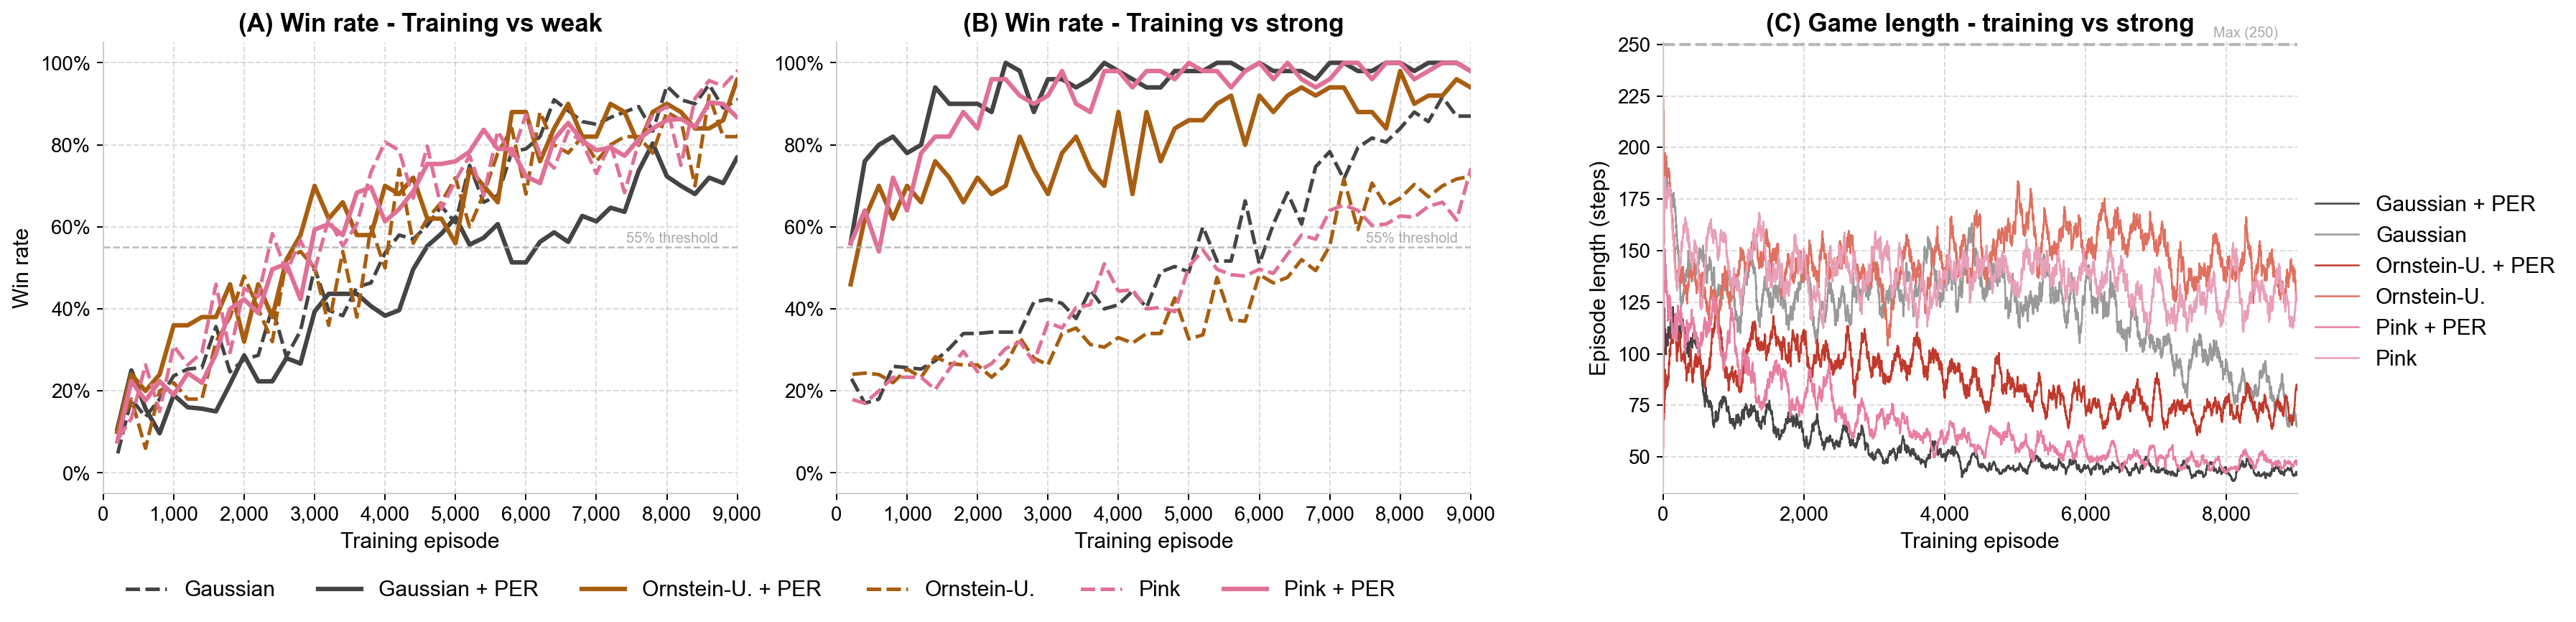

In [1266]:
fig = plot_three_panel(
    weak_win_runs=weak_runs,
    strong_win_runs=strong_runs,
    strong_ep_runs=strong_training,
    ep_smoothing=100,
    figsize=(18, 4.5),
    dpi=180,
)
fig.savefig("three_panel_TD3.pdf", bbox_inches="tight")
plt.show()

# Win rate across training

In [1262]:
def plot_win_rate_comparison(panels: dict, figsize=(14, 5), dpi=100):
    n_panels = len(panels)
    fig, axes = plt.subplots(1, n_panels, figsize=figsize, sharey=True, dpi=dpi)
    if n_panels == 1:
        axes = [axes]

    all_handles, all_labels = [], []

    for ax, (panel_title, runs) in zip(axes, panels.items()):
        for i, (label, df) in enumerate(runs.items()):
            c = get_noise_color(label)
            display_label = label.replace("\n", " — ")

            # PER runs get solid lines, non-PER get dashed
            #ls = "-" if "PER" in label else "--"
            line_style = get_line_style(label)

            ax.plot(df["episode"], df["win_rate"], color=c,
                    label=display_label, **line_style)

        ax.set_title(f"While training against {panel_title}")
        ax.set_xlabel("Training episode")
        ax.set_xlim(0, EPISODE_MAX)
        ax.set_ylim(-0.05, 1.05)
        ax.axhline(0.55, color="#aaaaaa", linestyle="--", linewidth=1,
                   alpha=0.8)
        ax.axhline(0.55, color="#aaaaaa", linestyle="--", linewidth=1, alpha=0.8)
        ax.text(EPISODE_MAX * 0.99, 0.56, "55% threshold",
                ha="right", va="bottom", fontsize=8, color="#aaaaaa")
        
        import matplotlib.ticker as mticker
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

        # collect handles for global legend (avoid duplicates)
        h, l = ax.get_legend_handles_labels()
        for hi, li in zip(h, l):
            if li not in all_labels:
                all_handles.append(hi)
                all_labels.append(li)

        #ax.legend(loc="lower right", fontsize=9)

    axes[0].set_ylabel("Win rate")

    sorted_handles, sorted_labels = sort_legend(all_handles, all_labels)
    fig.legend(sorted_handles, sorted_labels,
               loc="center right",
               bbox_to_anchor=(1.15, 0.5))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.18)  # make room for legend

    fig.tight_layout()
    return fig

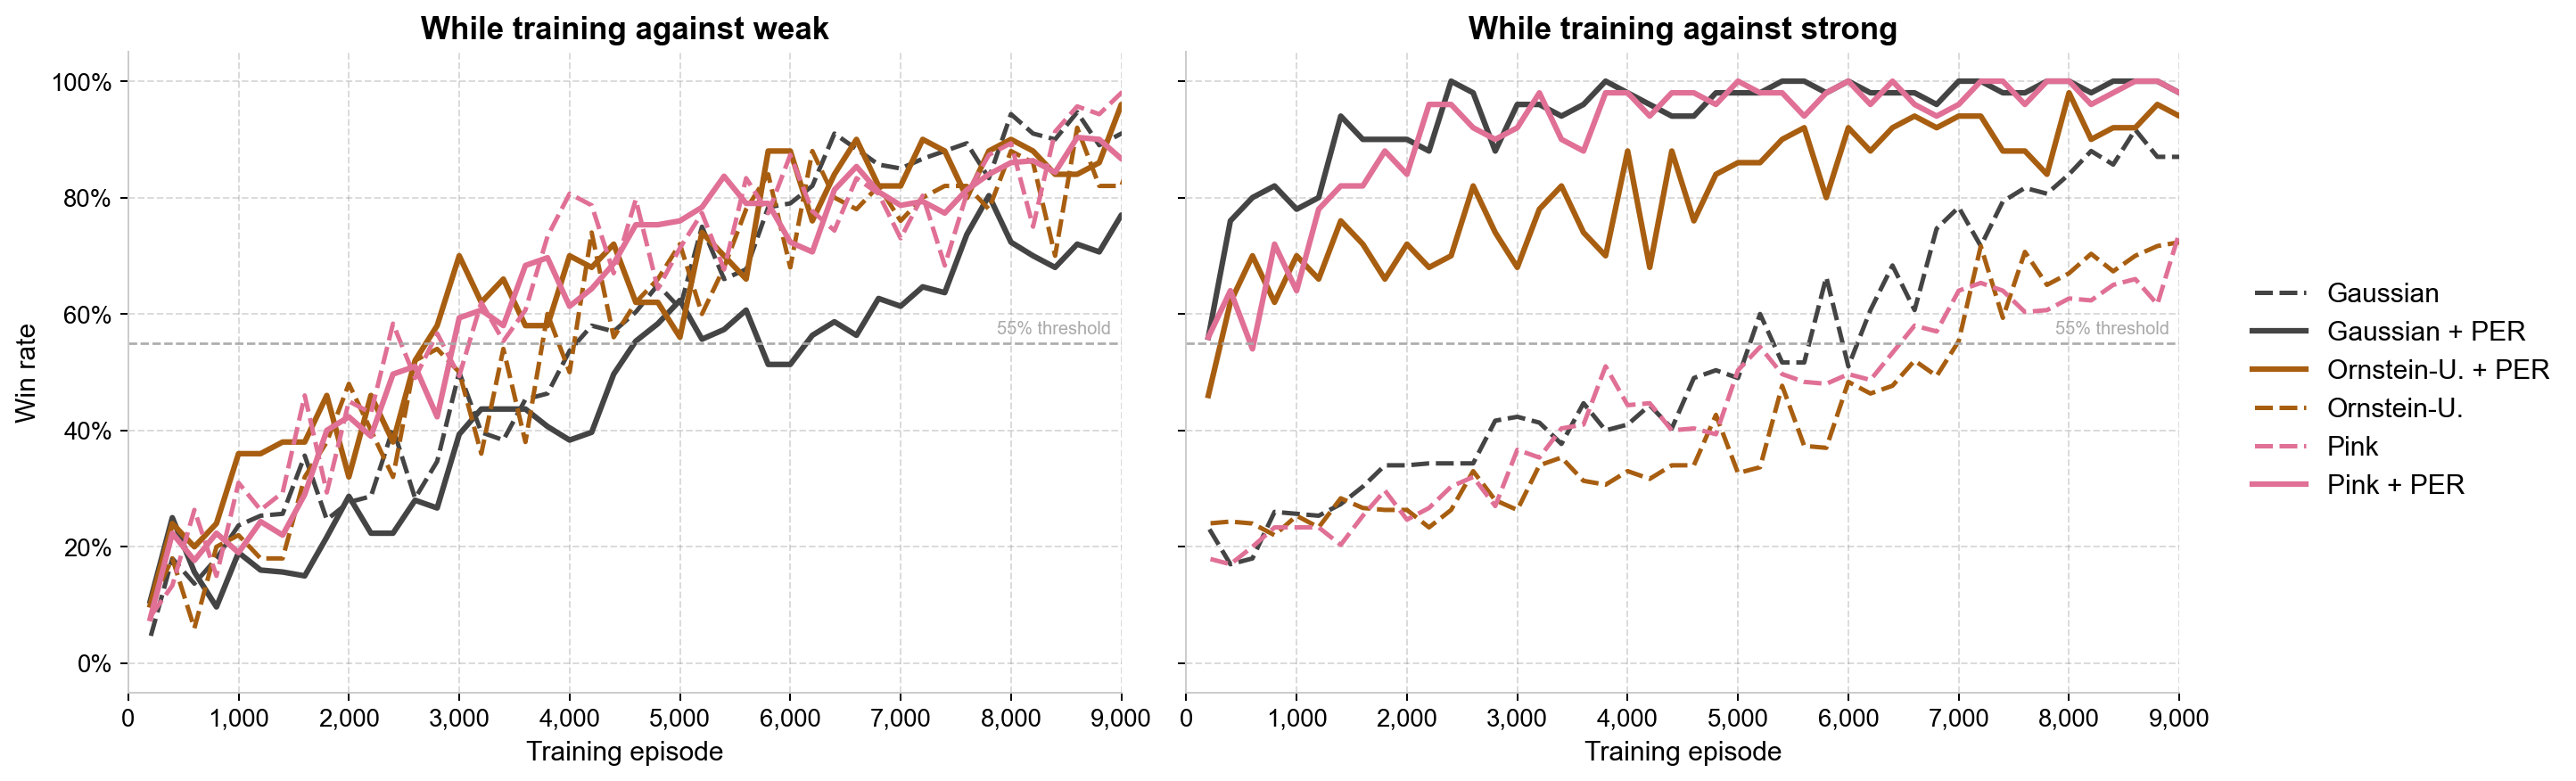

In [1263]:
fig = plot_win_rate_comparison(
    {"weak": weak_runs, "strong": strong_runs},
    figsize=(14, 5),
    dpi=180  
)
fig.savefig("win_rate_comparison_TD3.pdf")
plt.show()

In [1242]:
MIN_EPISODE = 40_000

def plot_win_rate_comparison_end(panels: dict, figsize=(14, 5), dpi=100):
    n_panels = len(panels)
    fig, axes = plt.subplots(1, n_panels, figsize=figsize, sharey=True, dpi=dpi)
    if n_panels == 1:
        axes = [axes]

    all_handles, all_labels = [], []

    for ax, (panel_title, runs) in zip(axes, panels.items()):
        for i, (label, df) in enumerate(runs.items()):
            c = get_noise_color(label)
            display_label = label.replace("\n", " — ")

            # PER runs get solid lines, non-PER get dashed
            #ls = "-" if "PER" in label else "--"
            line_style = get_line_style(label)

            ax.plot(df["episode"], df["win_rate"], color=c,
                    label=display_label, **line_style)

        ax.set_title(f"Against {panel_title} BasicOpponent")
        ax.set_xlabel("Training episode")
        ax.set_xlim(0, 50000)
        ax.set_ylim(-0.05, 1.05)
        ax.axhline(0.55, color="#aaaaaa", linestyle="--", linewidth=1,
                   alpha=0.8)
        ax.axhline(0.55, color="#aaaaaa", linestyle="--", linewidth=1, alpha=0.8)
        ax.text(50000 * 0.99, 0.56, "55% threshold",
                ha="right", va="bottom", fontsize=8, color="#aaaaaa")
        
        import matplotlib.ticker as mticker
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

        # collect handles for global legend (avoid duplicates)
        h, l = ax.get_legend_handles_labels()
        for hi, li in zip(h, l):
            if li not in all_labels:
                all_handles.append(hi)
                all_labels.append(li)

        #ax.legend(loc="lower right", fontsize=9)

    axes[0].set_ylabel("Win rate")

    sorted_handles, sorted_labels = sort_legend(all_handles, all_labels)
    fig.legend(sorted_handles, sorted_labels,
               loc="center right",
               bbox_to_anchor=(1.08, 0.5))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.18)  # make room for legend

    fig.tight_layout()
    return fig

# Episode length

In [1243]:
def get_line_style_episode(label: str) -> dict:
    """For episode length plot: all solid, differentiate only by color."""
    return {"linestyle": "-"}

In [1244]:
def plot_episode_length_comparison(panels: dict, smoothing=200, figsize=(12, 4.4), dpi=100):
    n_panels = len(panels)
    fig, axes = plt.subplots(1, n_panels, figsize=figsize, sharey=True, dpi=dpi)
    if n_panels == 1:
        axes = [axes]

    all_handles, all_labels = [], []

    for ax, (panel_title, runs) in zip(axes, panels.items()):
        for i, (label, df) in enumerate(runs.items()):
            c = get_noise_color_full(label)
            line_style = get_line_style_episode(label)

            smooth = df["episode_length"].rolling(smoothing, min_periods=1).mean()
            ax.plot(df["episode"], smooth, color=c, linewidth=1,
                    label=label, **line_style)

        ax.axhline(250, color="#aaaaaa", linestyle="--", linewidth=1, alpha=0.8)
        ax.text(EPISODE_MAX * 0.97, 252, "Max (250 steps)",
                ha="right", va="bottom", fontsize=8, color="#aaaaaa")

        ax.set_title(f"Against {panel_title} BasicOpponent")
        ax.set_xlabel("Training episode")
        ax.set_xlim(0, EPISODE_MAX)

        import matplotlib.ticker as mticker
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

        h, l = ax.get_legend_handles_labels()
        for hi, li in zip(h, l):
            if li not in all_labels:
                all_handles.append(hi)
                all_labels.append(li)

    axes[0].set_ylabel("Episode length (steps)")

    sorted_handles, sorted_labels = sort_legend(all_handles, all_labels)
    fig.legend(sorted_handles, sorted_labels,
               loc="center right",
               bbox_to_anchor=(1.08, 0.5))
    fig.tight_layout()
    return fig

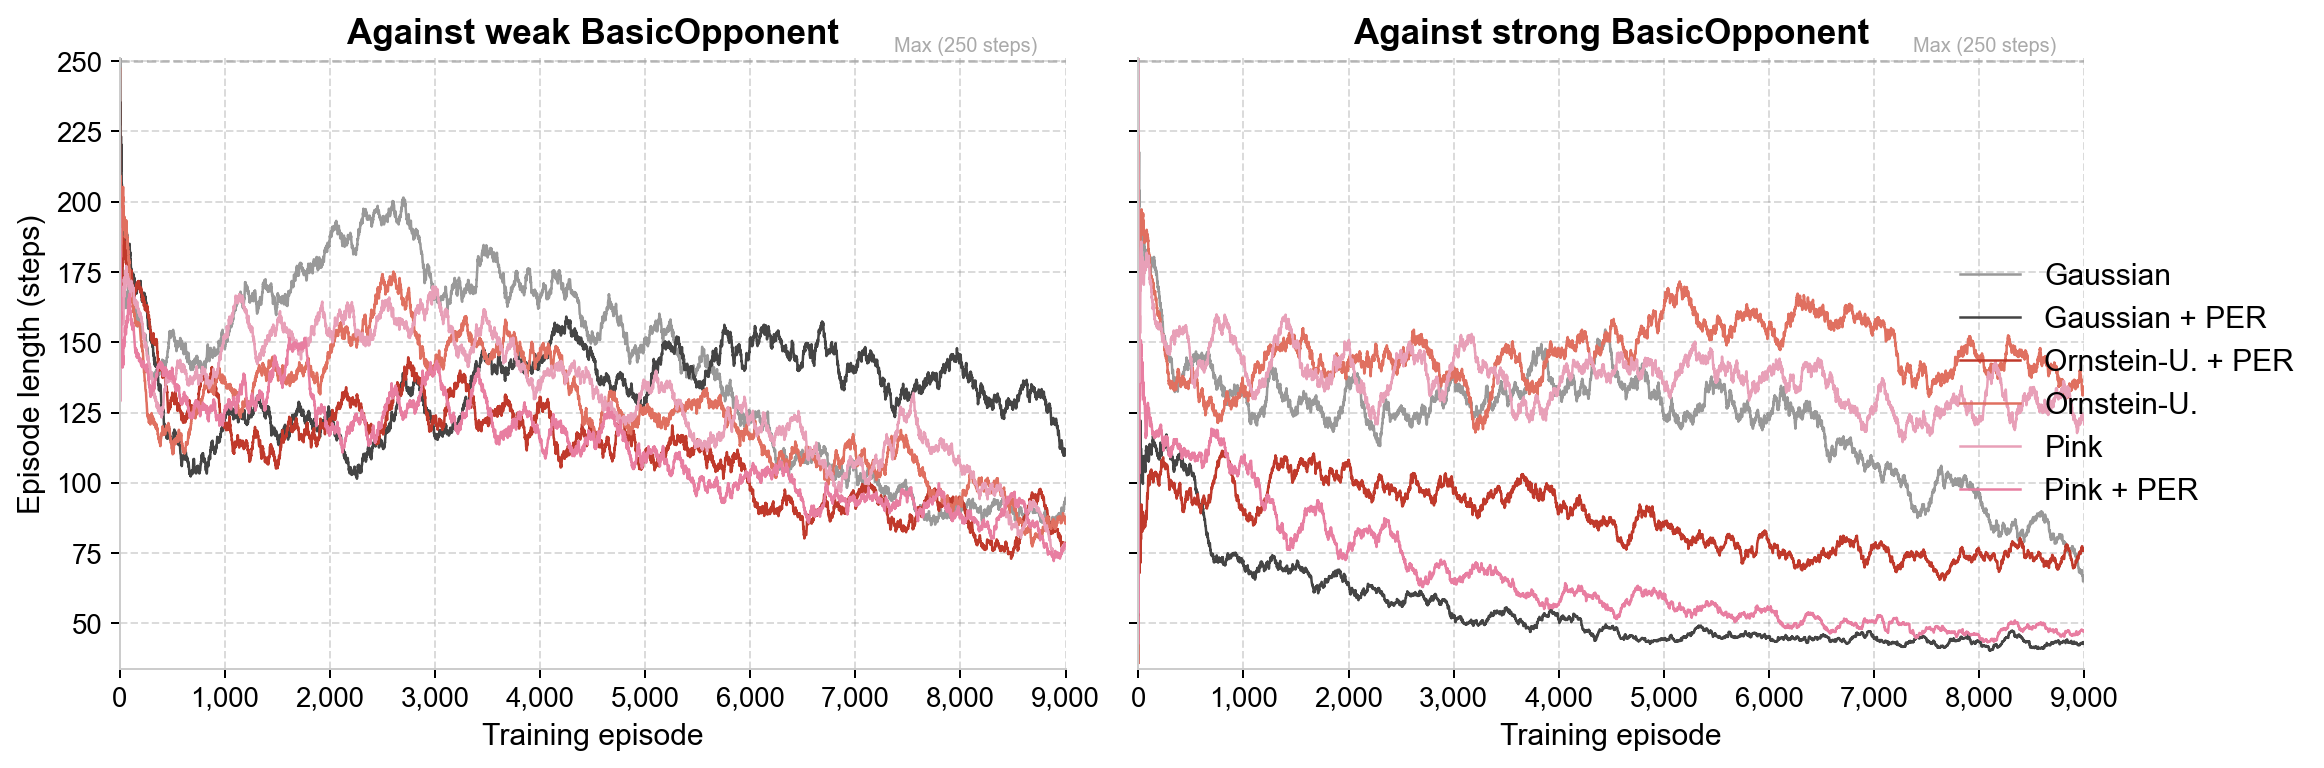

In [1245]:
fig = plot_episode_length_comparison(
    {"weak": weak_training, "strong": strong_training},
    smoothing=200,
    figsize=(12, 4.4),
    dpi=180,
)
#fig.savefig("episode_length_comparison_TD3.pdf")
plt.show()

OU + PER (red solid line) has lowest win rate against strong in the early episodes of training. 

Discussion: try OU with different mean reversion rates since our mean reversion rate might have clipped short exploration (agent doesnt sustain exploratory actions for long ednough)